# Tutorial: PyTorch to CasADi NMPC via ONNX
## Part 1: Training a PyTorch Model and Exporting to ONNX

Welcome to this tutorial on integrating PyTorch neural network models into CasADi-based Nonlinear Model Predictive Control (NMPC) using the ONNX (Open Neural Network Exchange) format.

In this first part, we will focus on:
1.  Defining a nonlinear dynamic system (the Van der Pol oscillator) for which we want to learn a model.
2.  Generating discrete-time training data from this system.
3.  Designing, training, and validating a simple Feedforward Neural Network (FNN) in PyTorch to approximate the system's one-step-ahead dynamics: $\hat{x}_{k+1} = f_{ANN}(x_k, u_k)$.
4.  Exporting the trained PyTorch model to the ONNX format.
5.  Verifying the exported ONNX model using `onnxruntime`.

**Prerequisites:** Basic familiarity with Python, NumPy, PyTorch, and the concept of neural networks.

### 1.1 Introduction to ONNX (Open Neural Network Exchange)

ONNX is an open format built to represent machine learning models. It defines a common set of operators – the building blocks of machine learning graphs – and a common file format to enable AI developers to use models with a variety of frameworks, tools, runtimes, and compilers.

**Why use ONNX for PyTorch-CasADi integration?**
-   **Framework Interoperability:** Allows us to train a model in a feature-rich deep learning framework like PyTorch and then deploy or use it in a different environment like CasADi, which is specialized for numerical optimization.
-   **Standardization:** Provides a standard way to represent the model's architecture and weights.
-   **Potential for Hardware Acceleration:** ONNX models can often be consumed by specialized runtimes that optimize for various hardware backends (CPUs, GPUs, NPUs).

CasADi has an importer for ONNX, which means it can load an ONNX model and convert it into a symbolic CasADi `Function`. This allows CasADi's automatic differentiation engine to compute gradients through the neural network model, which is crucial for NLP solvers used in NMPC.

### 1.2 System Definition: Van der Pol Oscillator

The Van der Pol oscillator is a non-conservative oscillator with non-linear damping. Its dynamics are given by:
$$ \frac{dx_1}{dt} = x_2 $$
$$ \frac{dx_2}{dt} = \mu (1 - x_1^2) x_2 - x_1 + u $$
Where:
- $x_1$: position-like state
- $x_2$: velocity-like state
- $\mu$: a scalar parameter indicating the nonlinearity and the strength of the damping (we'll fix $\mu=1$ for this example).
- $u$: an external control input.

Our goal is to train an ANN to learn the discrete-time one-step-ahead prediction: $x_{k+1} = f_{ANN}(x_k, u_k)$, where $x_k = [x_{1,k}, x_{2,k}]^T$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import onnx
import onnxruntime

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4)}) 

# Van der Pol oscillator ODE function
mu_vdp = 1.0 # Van der Pol parameter

def vdp_ode(t, x_state, u_input, mu):
    x1, x2 = x_state
    dx1_dt = x2
    dx2_dt = mu * (1 - x1**2) * x2 - x1 + u_input
    return [dx1_dt, dx2_dt]

# System dimensions
n_x_vdp = 2 # Number of states (x1, x2)
n_u_vdp = 1 # Number of inputs (u)

# Sampling time for data generation
Ts_vdp_data = 0.1 # seconds

### 1.3 Generating Discrete-Time Training Data

We'll simulate the Van der Pol oscillator with random inputs $u_k$ to generate sequences of $([x_k, u_k], x_{k+1})$.

In [4]:
N_data_points = 10000 # Number of data samples for training
x_vdp_data_list = []
u_vdp_data_list = []
x_next_vdp_data_list = []

x_current_vdp = np.array([1.0, 0.0]) # Initial state for data generation
np.random.seed(42) # for reproducibility

print("Generating Van der Pol data for ANN training...")
for i in range(N_data_points):
    # Random input u for excitation
    u_current_vdp = np.random.uniform(-2.0, 2.0)
    
    # Store current state x_k and input u_k
    x_vdp_data_list.append(x_current_vdp.copy())
    u_vdp_data_list.append(u_current_vdp)
    
    # Simulate one step forward to get x_k+1
    sol = solve_ivp(vdp_ode, [0, Ts_vdp_data], x_current_vdp, 
                      args=(u_current_vdp, mu_vdp), method='RK45', dense_output=False)
    x_next_vdp = sol.y[:, -1]
    x_next_vdp_data_list.append(x_next_vdp.copy())
    
    # Update current state for next iteration (optionally add small process noise)
    x_current_vdp = x_next_vdp #+ np.random.normal(0, 0.001, size=n_x_vdp)
    # Clip to prevent extreme values if system is unstable with random inputs
    x_current_vdp = np.clip(x_current_vdp, -3, 3)
    
    if (i+1) % 1000 == 0: print(f"  Generated {i+1}/{N_data_points} samples...", end='\r')

x_vdp_data_np = np.array(x_vdp_data_list)
u_vdp_data_np = np.array(u_vdp_data_list).reshape(-1, n_u_vdp)
x_next_vdp_data_np = np.array(x_next_vdp_data_list)
print("\nData generation complete.")
print(f"x_data shape: {x_vdp_data_np.shape}, u_data shape: {u_vdp_data_np.shape}, x_next_data shape: {x_next_vdp_data_np.shape}")

Generating Van der Pol data for ANN training...
  Generated 10000/10000 samples...
Data generation complete.
x_data shape: (10000, 2), u_data shape: (10000, 1), x_next_data shape: (10000, 2)


### 1.4 Data Preprocessing: Scaling

Neural networks generally train better when their inputs and outputs are scaled to a common range (e.g., [0, 1] or [-1, 1], or standardized to zero mean and unit variance).

In [5]:
# ANN input: concatenate current state x_k and current input u_k
ann_input_features_np = np.hstack((x_vdp_data_np, u_vdp_data_np))
# ANN output: next state x_k+1
ann_target_output_np = x_next_vdp_data_np

# Scalers
input_feature_scaler = MinMaxScaler(feature_range=(-1, 1))
output_target_scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit scalers ON TRAINING DATA ONLY (here, we use all generated data for simplicity, 
# but a proper train/val/test split should be done before fitting scalers)
ann_input_scaled_np = input_feature_scaler.fit_transform(ann_input_features_np)
ann_target_scaled_np = output_target_scaler.fit_transform(ann_target_output_np)

# Split into training and validation sets
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(
    ann_input_scaled_np, ann_target_scaled_np, test_size=0.2, random_state=123
)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_torch = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_torch = torch.tensor(y_val_scaled, dtype=torch.float32)

print(f"Shape of ANN input features (scaled): {X_train_torch.shape}")
print(f"Shape of ANN target outputs (scaled): {y_train_torch.shape}")

Shape of ANN input features (scaled): torch.Size([8000, 3])
Shape of ANN target outputs (scaled): torch.Size([8000, 2])


### 1.5 Designing and Training the PyTorch FNN

Training VDP ANN model...
Epoch 25/150, Train Loss: 0.000064, Val Loss: 0.000064
Epoch 50/150, Train Loss: 0.000014, Val Loss: 0.000011
Epoch 75/150, Train Loss: 0.000010, Val Loss: 0.000014
Epoch 100/150, Train Loss: 0.000015, Val Loss: 0.000011
Epoch 125/150, Train Loss: 0.000006, Val Loss: 0.000008
Epoch 150/150, Train Loss: 0.000008, Val Loss: 0.000003


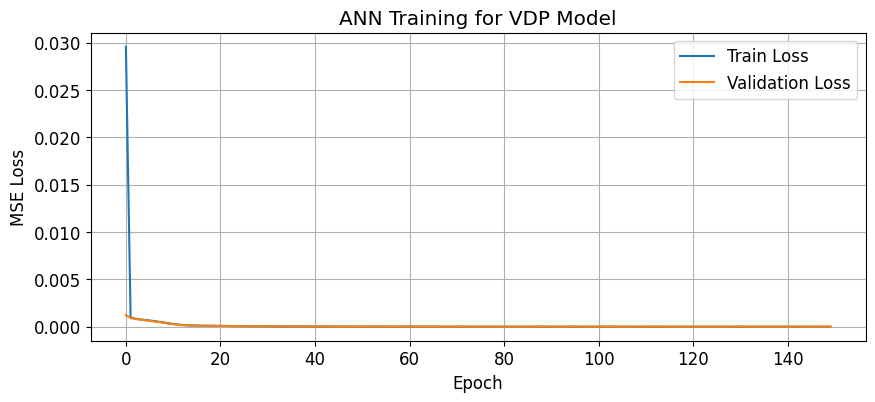

In [6]:
class VDP_ANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(VDP_ANN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.Tanh(), # Tanh or ReLU are common choices
            nn.Linear(hidden_size1, hidden_size2),
            nn.Tanh(),
            nn.Linear(hidden_size2, output_size)
            # Output layer is linear for regression of states
        )
    def forward(self, x):
        return self.network(x)

# ANN Hyperparameters
ann_input_dim = X_train_torch.shape[1]  # n_x + n_u
ann_output_dim = y_train_torch.shape[1] # n_x (for x_k+1)
h1_size = 64
h2_size = 64
lr = 0.001
epochs = 150 # Increase for better training if needed
ann_batch_size = 128

vdp_ann_model = VDP_ANN(ann_input_dim, h1_size, h2_size, ann_output_dim)
loss_fn = nn.MSELoss()
optimizer_ann = optim.Adam(vdp_ann_model.parameters(), lr=lr)

train_dataset_ann = TensorDataset(X_train_torch, y_train_torch)
train_loader_ann = DataLoader(train_dataset_ann, batch_size=ann_batch_size, shuffle=True)
val_dataset_ann = TensorDataset(X_val_torch, y_val_torch)
val_loader_ann = DataLoader(val_dataset_ann, batch_size=ann_batch_size, shuffle=False)

print("Training VDP ANN model...")
history_train_loss = []
history_val_loss = []
for epoch in range(epochs):
    vdp_ann_model.train()
    batch_train_loss = 0
    for xb, yb in train_loader_ann:
        y_pred = vdp_ann_model(xb)
        loss = loss_fn(y_pred, yb)
        optimizer_ann.zero_grad()
        loss.backward()
        optimizer_ann.step()
        batch_train_loss += loss.item()
    history_train_loss.append(batch_train_loss / len(train_loader_ann))

    vdp_ann_model.eval()
    batch_val_loss = 0
    with torch.no_grad():
        for xb_val, yb_val in val_loader_ann:
            y_pred_val = vdp_ann_model(xb_val)
            loss_v = loss_fn(y_pred_val, yb_val)
            batch_val_loss += loss_v.item()
    history_val_loss.append(batch_val_loss / len(val_loader_ann))

    if (epoch + 1) % 25 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {history_train_loss[-1]:.6f}, Val Loss: {history_val_loss[-1]:.6f}')

plt.figure()
plt.plot(history_train_loss, label='Train Loss')
plt.plot(history_val_loss, label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title('ANN Training for VDP Model')
plt.legend(); plt.grid(True); plt.show()

### 1.6 Validating the Trained ANN (Multi-Step Prediction)

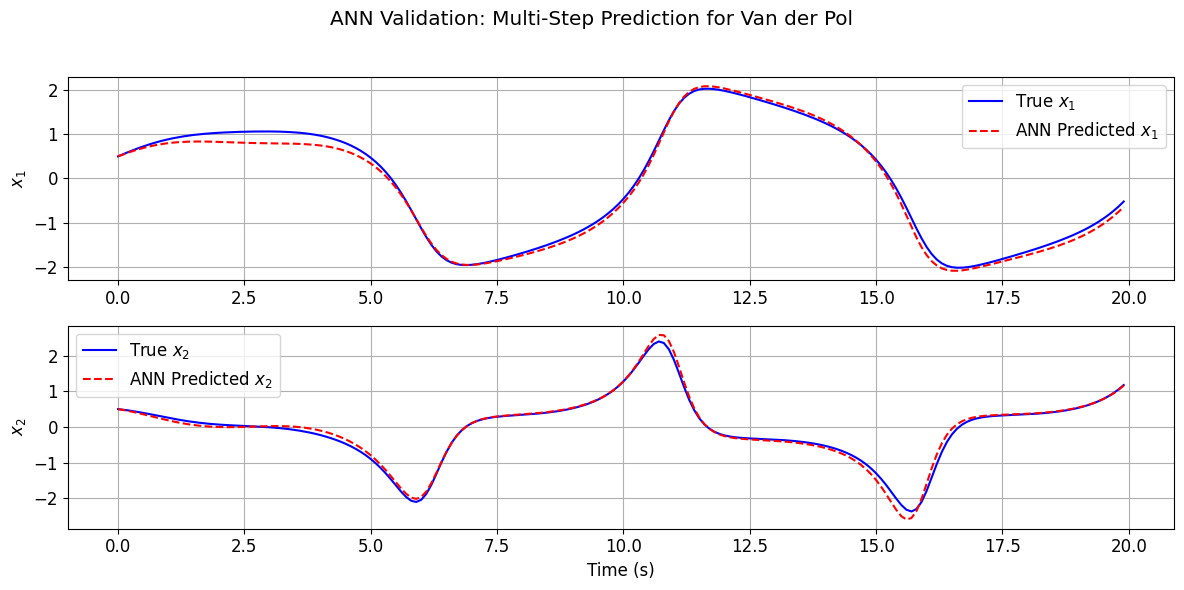

In [7]:
N_test_ann_sim = 200
t_test_ann = np.arange(0, N_test_ann_sim * Ts_vdp_data, Ts_vdp_data)
u_input_test_ann = 1.0 * np.sin(2 * np.pi * t_test_ann / (N_test_ann_sim * Ts_vdp_data / 2)) # Test input signal

x_true_ann_test_sim = np.zeros((N_test_ann_sim + 1, n_x_vdp))
x_pred_ann_test_sim = np.zeros((N_test_ann_sim + 1, n_x_vdp))

x_true_ann_test_sim[0, :] = np.array([0.5, 0.5]) # Initial condition for test
x_pred_ann_test_sim[0, :] = x_true_ann_test_sim[0, :].copy()

vdp_ann_model.eval()
with torch.no_grad():
    for k in range(N_test_ann_sim):
        # True system step
        sol_true_ann_test = solve_ivp(vdp_ode, [0, Ts_vdp_data], x_true_ann_test_sim[k, :], 
                                      args=(u_input_test_ann[k], mu_vdp), method='RK45')
        x_true_ann_test_sim[k+1, :] = sol_true_ann_test.y[:, -1]
        
        # ANN prediction step (multi-step ahead using its own previous prediction)
        current_ann_sim_input_unscaled = np.hstack((x_pred_ann_test_sim[k, :], u_input_test_ann[k]))
        current_ann_sim_input_scaled = input_feature_scaler.transform(current_ann_sim_input_unscaled.reshape(1, -1))
        current_ann_sim_input_torch = torch.tensor(current_ann_sim_input_scaled, dtype=torch.float32)
        
        pred_ann_sim_output_scaled = vdp_ann_model(current_ann_sim_input_torch)
        pred_ann_sim_output_unscaled = output_target_scaler.inverse_transform(pred_ann_sim_output_scaled.numpy())
        x_pred_ann_test_sim[k+1, :] = pred_ann_sim_output_unscaled.flatten()

plt.figure(figsize=(12, 6))
for i in range(n_x_vdp):
    plt.subplot(n_x_vdp, 1, i+1)
    plt.plot(t_test_ann, x_true_ann_test_sim[:-1, i], 'b-', label=f'True $x_{i+1}$')
    plt.plot(t_test_ann, x_pred_ann_test_sim[:-1, i], 'r--', label=f'ANN Predicted $x_{i+1}$')
    plt.ylabel(f'$x_{i+1}$'); plt.grid(True); plt.legend()
plt.xlabel('Time (s)'); plt.suptitle('ANN Validation: Multi-Step Prediction for Van der Pol'); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

## 1.7 Exporting the PyTorch Model to ONNX

Now we export our trained `vdp_ann_model` to the ONNX format.
**Important:** The model must be in `eval()` mode for export.

In [8]:
vdp_ann_model.eval() # Ensure model is in evaluation mode

# Define an example input tensor with the correct shape for the model's forward pass
# The first dimension is batch size (can be 1 for export)
dummy_input_batch_size = 1
example_ann_input = torch.randn(dummy_input_batch_size, ann_input_dim, dtype=torch.float32)

onnx_model_path = "vdp_ann_model.onnx"
input_names_onnx = ["input_scaled_features"] # Must match number of inputs to forward()
output_names_onnx = ["output_scaled_next_state"] # Must match number of outputs from forward()

try:
    torch.onnx.export(vdp_ann_model,               # model being run
                      example_ann_input,         # model input (or a tuple for multiple inputs)
                      onnx_model_path,           # where to save the model 
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=11,          # the ONNX version to export the model to (11 or 12 is good for CasADi)
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = input_names_onnx,   # the model's input names
                      output_names = output_names_onnx, # the model's output names
                      dynamic_axes={'input_scaled_features' : {0 : 'batch_size'}, # variable length axes
                                    'output_scaled_next_state' : {0 : 'batch_size'}})
    print(f"PyTorch model successfully exported to {onnx_model_path}")
except Exception as e:
    print(f"Error during ONNX export: {e}")

PyTorch model successfully exported to vdp_ann_model.onnx


### 1.8 (Optional but Recommended) Verifying the ONNX Model

We can use `onnx` library to check the model and `onnxruntime` to run inference and compare with PyTorch.

In [9]:
try:
    onnx_model = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model checked successfully.")

    # Create ONNX Runtime inference session
    ort_session = onnxruntime.InferenceSession(onnx_model_path)

    # Prepare a test input (same as used for PyTorch model)
    # Use the SCALED input that the ANN was trained on
    test_input_np_scaled = X_val_scaled[0:1, :] # Take one sample from validation set
    ort_inputs = {ort_session.get_inputs()[0].name: test_input_np_scaled.astype(np.float32)}

    # Run inference with ONNX Runtime
    ort_outs = ort_session.run(None, ort_inputs)
    onnx_prediction_scaled = ort_outs[0]

    # Get prediction from original PyTorch model for the same input
    vdp_ann_model.eval()
    with torch.no_grad():
        pytorch_input_tensor = torch.tensor(test_input_np_scaled, dtype=torch.float32)
        pytorch_prediction_scaled = vdp_ann_model(pytorch_input_tensor).numpy()
    
    # Compare predictions
    print("\nComparing PyTorch and ONNX Runtime predictions (on SCALED data):")
    print(f"PyTorch output: {pytorch_prediction_scaled}")
    print(f"ONNX output:    {onnx_prediction_scaled}")
    if np.allclose(pytorch_prediction_scaled, onnx_prediction_scaled, atol=1e-6):
        print("Predictions are close. ONNX export likely successful!")
    else:
        print("WARNING: Predictions differ significantly!")
        print("Difference:", pytorch_prediction_scaled - onnx_prediction_scaled)

except Exception as e:
    print(f"Error during ONNX model verification: {e}")

ONNX model checked successfully.

Comparing PyTorch and ONNX Runtime predictions (on SCALED data):
PyTorch output: [[0.8232465  0.27351573]]
ONNX output:    [[0.82324654 0.2735158 ]]
Predictions are close. ONNX export likely successful!


## Summary of Part 1

In this part, we have successfully:
1.  Defined a nonlinear dynamic system (Van der Pol oscillator).
2.  Generated discrete-time data samples $([x_k, u_k], x_{k+1})$.
3.  Preprocessed the data by scaling.
4.  Trained a PyTorch Feedforward Neural Network to learn the one-step-ahead dynamics $x_{k+1} = f_{ANN}(x_k, u_k)$.
5.  Validated the ANN's multi-step prediction capability.
6.  Exported the trained PyTorch model to the ONNX format.
7.  Verified the ONNX model's structure and its inference consistency with the original PyTorch model.

**Next Steps (Part 2 of this Tutorial):**
We will now take the `vdp_ann_model.onnx` file and import it into CasADi to create a symbolic CasADi function. This function will then be used as the prediction model within an NMPC optimization problem.